# Anomaly Detection in Time Series using RW-LASSO and Application in Statistical Arbitrage

## Context

Let $f(t) \in \mathbb{R}^N$ be the value of a vector of $N$ time series at time $t$. We are interested in both detecting when an anomaly occurrs and in which of the $N$ time series is occurring. In this setting we say, qualitatively, that an anomaly occurs when at least one of the time series assume a value unlikely given all the others time series. Traditional techniques either focus on single time series or lack in the explainability needed. Some univariate approach, like *Z-Score* (also known as standard score), work well in stationary cases but falls short when abrupt changes happen. To overcome these issues our approach consists in computing, for each time series $f_i$, a syntetic time series obtained as weighted sum of all the others:

$$
\hat{f_i}(t) = \sum_{j \neq i} a_{i, j} f_j(t)
$$

The difference between the true and the estimated one is our score $\delta_i(t) = f_i(t) - \hat{f_i}(t)$ and it is used to decide whether there is an anomaly in the i-th time series at time $t$. In particular we say that an anomaly occurs if $\delta_i(t)$ is not in the interval $[L, U]$, where $L$ and $U$ are respectively the lower and the upper bounds.

$$
Prediction =   \begin{cases}
NotAnomaly & \delta_i(t) \in [L, U] \\
Anomaly & \delta_i(t) \notin [L, U] \\
\end{cases}
$$

## Data
We will be using the daily log returns of $441$ stocks from *2010-01-06* to *2021-12-27*. Given a daily price time series $p(t)$ the daily log returns are computed as $f(t) = log(p(t)) - log(p(t-1))$. We chose this quantity since it represents a good approximation for the percentage change and makes it easy to evaluate the comulative returns as the sum of the sigle returns.

In [1]:
from tqdm.notebook import tqdm
import numpy as np
from scipy.linalg import sqrtm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from pyvis.network import Network
import networkx as nx
from sklearn import metrics
plt.rcParams['figure.figsize'] = (16, 8)

In [2]:
options = '''const options = {
  "nodes": {
    "borderWidth": 1,
    "borderWidthSelected": 2,
    "opacity": 1,
    "size": null,
    "color": {
      "background": "rgb(151, 194, 252)",
      "border": "rgb(43, 124, 233)",
      "highlight": {
          "background": "#fca697"
      },
      "hover": {
          "background": "#fcd997"
      }
    }
  },
  "edges": {
    "color": {
      "color": "rgb(151, 194, 252)",
      "highlight": "#fca697",
      "hover": "#fcd997"
    },
    "physics": false,
    "selfReferenceSize": null,
    "selfReference": {
      "angle": 0.7853981633974483
    },
    "smooth": {
      "type": "continuous",
      "forceDirection": "none"
    }
  },
  "interaction": {
    "hover": true
  },
  "physics": {
    "forceAtlas2Based": {
      "springLength": 100,
      "damping": 0.45
    },
    "minVelocity": 0.5,
    "solver": "forceAtlas2Based"
  }
}'''

In [3]:
# Load Data
prices = pd.read_csv('prices.csv', index_col='Date')
N = len(prices.columns)

# Extract log-returns
log_prices = np.log2(prices).reset_index(drop=True)
log_prices -= log_prices.iloc[0]
log_returns = log_prices.diff().dropna()
log_returns.index = pd.to_datetime(prices.index[:-1])

In [4]:
log_returns

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WY,WYNN,XEL,XLNX,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.005135,-0.061046,0.012525,-0.023132,-0.013706,-0.022156,0.007990,0.015256,-0.003065,-0.002740,...,-0.016041,-0.019049,0.002768,-0.009820,0.012415,0.009473,-0.010351,-0.000466,-0.011133,0.120294
2010-01-06,-0.001872,0.041901,-0.000357,-0.002670,-0.023324,0.000000,0.011903,-0.001349,-0.028270,-0.011474,...,-0.006467,0.030486,-0.006234,-0.014564,-0.004540,0.018763,-0.000415,0.032722,-0.036526,0.153157
2010-01-07,-0.000468,-0.027798,0.005691,0.009560,0.015591,-0.029497,0.007356,-0.005750,-0.007843,0.008270,...,-0.013348,-0.010374,0.000694,0.020926,-0.005799,0.000000,0.000415,-0.030626,-0.004697,-0.023544
2010-01-08,0.000937,-0.028345,-0.014269,-0.012783,0.015972,-0.026537,0.007319,-0.001356,-0.018999,-0.008270,...,0.009454,-0.004683,0.013812,-0.015083,0.016096,0.018522,0.024718,0.031537,0.004697,0.008765
2010-01-11,-0.017425,0.011404,-0.025318,-0.016505,0.009825,-0.034330,-0.004178,-0.009189,-0.022081,-0.061180,...,-0.016996,0.006381,0.017082,-0.040808,-0.007201,-0.010440,0.027111,-0.028050,-0.001564,-0.040767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,-0.009559,0.029487,-0.027716,-0.011765,0.009534,0.003106,-0.022588,-0.038596,-0.017916,-0.015261,...,-0.056030,-0.026190,0.002582,-0.029052,-0.021062,-0.022321,-0.003942,-0.023590,-0.044157,-0.043069
2021-12-20,0.033559,0.066811,0.007435,0.027277,0.018203,0.071078,0.003096,0.026347,0.020195,0.031873,...,0.012432,0.095518,-0.006986,0.073695,0.032313,0.010387,0.019603,0.042683,0.023640,0.053638
2021-12-21,0.026186,0.011104,0.020095,0.021933,0.002259,0.047838,0.039139,0.039122,0.016620,0.001759,...,0.013813,-0.007541,0.008457,0.058684,0.011638,0.038166,0.013566,0.026498,0.000547,0.004906


## Problem Formulation

In order to obtain the best estimator for the $f_i$'s we can define a suitable optimization problem. Let $X$ be the $B \cdot t \times N$ regression matrix and $A$ the $N \times N$ weights matrix, we are interested in minimizing the *Frobenius Norm* of the reconstructed matrix $\Delta = X - X A$. Obvious we need to put a constraint on the main diagonal entries of $A$ in order to drop the trivial solution. Moreover, since we aim to retrieve a sparse solution we add an *L1-penalty* to the loss.

$$
\begin{align}
\hat{A} &= \underset{A}{\mathrm{argmin}} \ \| X - X A \|^2_2 + \lambda \| A \|_1 \\
&\text{s.t. } diag(A) = 0
\end{align}
$$

Since it makes the computation easier and it is completely equivalent from now on we will use the weighted laplacian $L = I -A$ instead of the weighted adjacency $A$. The problem can therefore be rewritten as 

$$
\begin{align}
\hat{L} &= \underset{L}{\mathrm{argmin}} \ \| X L \|^2_2 + \lambda \| L - I \|_1 \\
&\text{s.t. } diag(L) = I
\end{align}
$$

## Constrained Gradient Descent Step

Since we formulated our solution as output of a constrained optimizaion problem here we prove that: *the solution to the linear optimization problem in which a subset* $\mathcal{I}$ *of the unkwown pararameter vector* $\beta$ *is constrained to be equal to some fixed values* $b_i$

$$
\begin{align}
\hat{\beta} &= \underset{\beta}{\mathrm{argmin}} \ \| y - X \beta \|^2_2 \\
&= \underset{\beta}{\mathrm{argmin}} \frac{1}{2} \left( \beta^T X^T X \beta - 2 \beta^T X^T y\right) \\
&\text{s.t. } \beta_i = b_i \ \forall \ i \in \mathcal{I}
\end{align}
$$

*can be computed using a variation of the gradient descent algorithm in which the constrained parameters are initialised to the constraints* $\beta^{(0)}_i = b_i$ *and never updated. The gradient can therefore be computed as: * 
$$\nabla L(\beta) = (X^T X \beta - X^T y) \circ I \\
\text{where: } I_i = \begin{cases}
0 & i \in \mathcal{I} \\
1 & i \notin \mathcal{I}
\end{cases}$$

In order to prove it first we analize the case of a single constraint $\beta_i = 0$.

Let $X^*$ be an $N \times K$ regression matrix, $y$ an $N$ observations vector and $\hat{\beta^*} = \underset{\beta}{\mathrm{argmin}} \ \| y - X^* \beta \|^2_2$ the global optimum computed using gradient descent. 

Let a second optimization problem where the regression matrix of size $N \times K+1$ is obtained stacking a noise variable vector onto $X^*$: $X = \Big[ X^* \Big| * \Big]$. In this case we fix the last component of the parameter vector $\beta_{K+1}$ to $0$.

$$
\begin{align}
\hat{\beta} &= \underset{\beta}{\mathrm{argmin}} \ \| y - X \beta \|^2_2 \\
&\text{s.t. } \beta_{K+1} = 0
\end{align}
$$

Doing so the solution to this problem has to assume the following shape: $\hat{\beta} = \Big[ \hat{\beta^*} \Big| 0 \Big]$. 

To prove that our algorithm actually converges to the true optimum we compare the updates, if the updates are equal then they converge to the same value. The update rule at the m-th iteration is $\beta^{(m+1)} = \beta^{(m)} - \alpha \nabla L(\beta^{(m)})$ for both algorithms therefore the only difference lies in the gradient of the loss function. 

The gradient of the i-th component in the vanilla gradient descent is

$$
\nabla L(\beta^*)_i = \sum_{l = 1}^N \left(\sum_{j = 1}^K X_{l, i} X_{l, j} \beta_j^* - X_{l, i} y_l\right)
$$

The gradient of the i-th component for the second optimization problem is

$$
\begin{align}
\nabla L(\beta)_i &= \sum_{l = 1}^N \left(\sum_{j = 1}^{K+1} X_{l, i} X_{l, j} \beta_j - X_{l, i} y_l\right) \circ I_i \\
&= \sum_{l = 1}^N \left(\sum_{j = 1}^{K} X_{l, i} X_{l, j} \beta_j + X_{l, i} X_{l, K+1} \beta_{K+1} - X_{l, i} y_l\right) \circ I_i \\
\beta_{K+1}=0 \Rightarrow \nabla L(\beta)_i &= \sum_{l = 1}^N \left(\sum_{j = 1}^K X_{l, i} X_{l, j} \beta_j^* - X_{l, i} y_l\right) \circ I_i
\end{align}
$$

since $\beta_{K+1} = 0$ and  $I_i = \begin{cases} 0 & i = K+1 \\ 1 & i \neq K+1 \end{cases}$ we get that the two gradients are equal $\nabla L(\beta)_i = \nabla L(\beta^*)_i$ if $i \neq K+1$ and the gradient is null $\nabla L(\beta)_{K+1} = 0$ if $i=K+1$.

We proceed now proving the general case $\beta_i = b_i$.

Let $X$ be the same $N \times K+1$ regression matrix as before. The quantity we are trying to estimate is $y = X\beta$, if we fix the K+1-th component imposing the $\beta_{K+1} = b$ we can move the effect of the K+1-th variable on the left hand side and remove the optimization constraint

\begin{align}
y &= X\beta = X_{, \sim K+1} \beta_{\sim K+1} + X_{, K+1} \beta_{K+1} \\
\Rightarrow y^* &= y - X_{, K+1} \beta_{K+1} = y - X_{, K+1} b \\ 
y^* &= X_{, \sim K+1} \beta_{\sim K+1}
\end{align}

hence we obtain a new optimization problem with $K$ variables for which we already know how to compute the gradient:

$$
\hat{\beta}_{\sim K+1} = \underset{\beta_{\sim K+1}}{\mathrm{argmin}} \ \| y^* - X_{, \sim K+1} \beta_{\sim K+1} \|^2_2 \\
\nabla L(\beta_{\sim K+1})_i = \sum_{l = 1}^N \left(\sum_{j = 1}^K X_{l, i} X_{l, j} \beta_j - X_{l, i} y^*_l\right)
 = \sum_{l = 1}^N \left(\sum_{j = 1}^K X_{l, i} X_{l, j} \beta_j - X_{l, i} y_l + X_{l, i} X_{l, K+1} b\right)
$$

We can now compare the unconstrained problem update with our update for the constrained one:


\begin{align}
\hat{\beta} &= \underset{\beta}{\mathrm{argmin}} \ \| y - X \beta \|^2_2 \\
&\text{s.t. } \beta_{K+1} = b 
\end{align}
\begin{align}
\nabla L(\beta)_i &= \sum_{l = 1}^N \left(\sum_{j = 1}^{K+1} X_{l, i} X_{l, j} \beta_j - X_{l, i} y_l\right) \circ I \\
&= \sum_{l = 1}^N \left(\sum_{j = 1}^{K} X_{l, i} X_{l, j} \beta_j + X_{l, i} X_{l, K+1} \beta_{K+1} - X_{l, i} y_l\right) \circ I  \\
&= \sum_{l = 1}^N \left(\sum_{j = 1}^{K} X_{l, i} X_{l, j} \beta_j + X_{l, i} X_{l, K+1} b - X_{l, i} y_l\right) \circ I 
\end{align}

As we can see the two gradients are equal $\nabla L(\beta_{\sim K+1})_i = \nabla L(\beta)_i$ for $i \neq K+1$ and $\nabla L(\beta)_i = 0$ for $i=K+1$ therefore using our update rule we reach the constrained optimum.

## RW-LASSO

The problems we are dealing with are not proven to be stationary, i.e. the parameters estimated at time $t$ may be not correct at time $t+\tau$, therefore a recursive weighted LASSO algorithm is used in the estimation.

If the sparsity constraint is not present, the goal of adaptive estimation can be accoplished by the recursive least-squares (*RLS*) algorithm:

$$
\hat{L_t}^{RLS} = \underset{x}{\mathrm{argmin}} \sum_{\tau = 1}^t \beta^{t - \tau} \| X_t L \|
$$

where $\beta \in (0, 1]$ is the forgetting factor and $X_t$ is the $B \times N$ regression matrix at time $t$.

Including the *L1-penalty* in the previous RLS cost function we obtain the R-LASSO loss:

$$
J_t(L) = \frac{1}{2} \sum_{\tau = 1}^t \beta^{t - \tau} \| X_t L \| + \lambda_t \| L - I \|_1
$$

where $\lambda_t$ is the penalty parameter at time $t$. In order to overcome some limitation and improve performance we look for a penalty term that weighs differently the entries $|l_{i, j}|$ in the L1 norm. We use as weight function

$$
w_{\mu_t}(|x|) :=  \frac{(a \mu_t - |x|)_+}{\mu_t(a-1)} u(|x| - \mu_t) + u(\mu_t - |x|)
$$

where $u(\cdot)$ stands for the step function, $(\cdot)_+$ denotes the non-negative part of the quantity in parentheses and the parameter $a$ is set to $a=3.7$. Using this function we can write the RW-LASSO cost function as

$$
J_t^{RW-LASSO}(L) = \frac{1}{2} \sum_{\tau = 1}^t \beta^{t - \tau} \| X_t L \| + \lambda_t \sum_{i=1}^{N} \sum_{j=1}^{N} w_{\mu_t}(|\hat{l}_{i,j}^{RLS}|) \ | l_{i, j} - I_{i, j} |
$$

Both *R-LASSO* and *RW-LASSO* can be estimated using a subgradient iteration method. In order to do that we first have to define the gradient for the constrained differentiable OLS cost $\mathcal{L}_t(L)$. From the proof above we know that defined $C_t = \beta C_{t-1} - X_t^T X_t$ we can write the gradient as:

$$
\begin{align}
\nabla \mathcal{L}_t(L)^* &= \nabla \mathcal{L}_t(L) \circ (\mathbb{1} - I) \\
&= \nabla \mathcal{L}_t(L) \circ I^* \\
&= C_t L \circ I^*
\end{align}
$$

where $I^*_{i, j} = 1 \iff L_{i, j}$ is allowed to vary.

The subgradient update for the {i, j}-th entry is

$$
\nabla J_t(L)_{i, j} = 
\begin{cases}
\nabla \mathcal{L}_t(L)^*_{i, j} + \lambda_t w_{\mu_t}(|\hat{l}_{i,j}^{RLS}|) \ sign(l_{i, j}) & l_{i, j} \neq 0 \\
\nabla \mathcal{L}_t(L)^*_{i, j} - \lambda_t w_{\mu_t}(|\hat{l}_{i,j}^{RLS}|) & l_{i, j} = 0, &\nabla \mathcal{L}_t(L)^*_{i, j} > \lambda_t \\
\nabla \mathcal{L}_t(L)^*_{i, j} + \lambda_t w_{\mu_t}(|\hat{l}_{i,j}^{RLS}|) & l_{i, j} = 0, &\nabla \mathcal{L}_t(L)^*_{i, j} < -\lambda_t \\
0 & l_{i, j} = 0, &- \lambda_t < \nabla \mathcal{L}_t(L)^*_{i, j} < \lambda_t
\end{cases}
$$

please notice that in practice the condition $l_{i, j} = 0$ is replaced by $|l_{i, j}| < \delta << 1$.

The laplacian matrix can therefore be updated according to:

$$
L_t^{(i+1)} = L_t^{(i)} - \alpha_i \nabla J_t(L_t^{(i)}) \circ I^*
$$

A vanishing stepsize of the form $\alpha_i = \alpha / \sqrt{i}$ guarantees convergence (as $i \rightarrow \infty$) to the constrained minimum of $J_t$.

In [5]:
class SelfRWLasso:
    def __init__(self, beta, lambda_, mu, lr=5e-3, delta = 1e-4, max_iter=2000, tol=1e-5):
        self.beta = beta
        self.lambda_ = lambda_
        self.mu = mu
        self.alpha = lr
        self.delta = delta
        self.tol = tol
        self.max_iter = max_iter
        self.a = 3.7
        self.L_rls = None
        self.L = None
        self.C = 0 
        self.I_star = None 
        self.t = 0 # Timestep counter
        self.B = None # Number of samples per timestep
        self.N = None # Number of variables
        
    def compute_weights(self):
        module = np.abs(self.L_rls)
        step = np.heaviside(module - self.mu, .5)
        ratio = np.maximum(self.a * self.mu - module, 0) / (self.mu * (self.a - 1))
        w = ratio * step + (1-step)
        return w
    
    def fit_rls(self):
        loss_i = np.linalg.norm(self.X_t @ self.L_rls, ord='fro')**2 / (2 * self.N**2)
        alpha = self.alpha
        for i in range(1, self.max_iter + 1):
            # Evaluate learning rate alpha
            alpha_i = alpha / np.sqrt(i)
            # Evaluate gradient
            grad_L_rls = self.C @ self.L_rls
            # Update RLS laplacian
            self.L_rls -= alpha_i * grad_L_rls * self.I_star
            # Check for stop loss
            loss_i_plus_1 = np.linalg.norm(self.X_t @ self.L_rls, ord='fro')**2 / (2 * self.N**2)
            update = loss_i - loss_i_plus_1
            if update < -self.tol:
                alpha /= 2
            if np.abs(update) < self.tol:
                break
            loss_i = loss_i_plus_1
        if update < -self.tol:
            raise Exception(f'RWLASSO - Update less than 0! Update: {"{:e}".format(update)}')
            
    def fit_rwlasso(self):
        if self.L is None:
            self.L = self.L_rls
        loss_i = (np.linalg.norm(self.X_t @ self.L, ord='fro')**2 / 2 + np.abs(self.L).sum()) / self.N**2
        alpha = self.alpha
        for i in range(1, self.max_iter + 1):
            # Evaluate learning rate alpha
            alpha_i = alpha / np.sqrt(i)
            
            # Evaluate RLS gradient
            grad_L_rls = self.C @ self.L
            
            # Evaluate penalty term
            w = self.compute_weights()
            L_eq_0 = np.abs(self.L) < self.delta
            penalty_term = self.lambda_ * w * (np.sign(self.L) * (1 - L_eq_0) -
                                              np.sign(grad_L_rls) * (np.abs(self.L) > self.lambda_) * L_eq_0)
            
            # Compute whole gradient
            grad_J = grad_L_rls + penalty_term
            
            # Update laplacian
            self.L -= alpha_i * grad_J * self.I_star
            # Check for stop loss
            loss_i_plus_1 = (np.linalg.norm(self.X_t @ self.L, ord='fro')**2 / 2 + np.abs(self.L).sum()) / self.N**2
            update = loss_i - loss_i_plus_1
            if update < -self.tol:
                alpha /= 2
            if np.abs(update) < self.tol:
                break
            loss_i = loss_i_plus_1
        self.L *= np.abs(self.L) > self.delta
        if update < -self.tol:
            raise Exception(f'RWLASSO - Update less than 0! Update: {"{:e}".format(update)}')
        
    def fit(self, X, B=1, trace_L=False, predict_self=False, predict_next=False, burnin=0, bias=True):
        # Set B
        if self.B is None:
            if B == -1:
                B = X.shape[0]
            self.B = B
            
        # Include bias column
        if bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        
        # Evaluate number of timestep
        t = int(np.ceil(X.shape[0] / self.B))
        # Update timestep counter
        self.t += t
        
        # Initialise parameters if needed
        if self.L is None:
            self.N = X.shape[1]
            self.I_star = 1 - np.eye(self.N) 
            init_asymm_L = np.random.rand(self.N, self.N) / (2 * self.N)
            self.L_rls = np.eye(self.N) - (init_asymm_L + init_asymm_L.T) * self.I_star
        
        Ls = []
        Deltas_self = []
        Deltas_next = []
        # Training Loop
        X_t = X[: self.B]
        for tau in tqdm(range(t)):
            
            self.X_t = X_t
            self.C = (self.C * self.beta + X_t.T @ X_t)
            
            if tau < burnin:
                continue
            
            # Fit RLS and RW-Lasso
            self.fit_rls()
            self.fit_rwlasso()
            
            if trace_L:
                Ls.append(self.L)
                
            if predict_self:
                Deltas_self.append(X_t @ L)
                
            X_t_1 = X[tau*self.B: (tau + 1)*self.B]
            if predict_next:
                Deltas_next.append(X_t_1 @ L)
                
            X_t = X_t_1
        
        res = {'L': self.L}
        if trace_L:
            res['Ls'] = Ls
            
        if predict_self:
            res['Delta'] = np.array(Deltas_self)
            
        if predict_next:
            res['DeltaFW'] = np.array(Deltas_next)
            
        return res
    
    def predict(self, X):
        return X @ self.L

In [6]:
def compute_Delta(log_returns, _beta = 0.9, _lambda = 3e-3, _mu = 1e-3, B = 1, bias = False):
    X = log_returns.values
        
    model_srwl = SelfRWLasso(_beta, _lambda, _mu)
    res_srwl = model_srwl.fit(X, B=B, trace_L=True, burnin=0, bias=bias)
    
    log_returns_bias = log_returns.copy()
    if bias:
        log_returns_bias['bias'] = 1
        
    Delta = pd.DataFrame(np.array([(x @ L) for x, L in zip(log_returns_bias.values, res_srwl['Ls'])]),
                     columns=log_returns_bias.columns)
    if bias:
        Delta = Delta.iloc[:, :-1]
        
    Delta.index = log_returns.index
    
    return Delta

In [138]:
_beta = 0.9
_lambda = 6e-3
_mu = _lambda / 3
B = 1
bias = False
X = log_returns.values

model_srwl = SelfRWLasso(_beta, _lambda, _mu)
res_srwl = model_srwl.fit(X, B=B, trace_L=True, burnin=0, bias=bias)

  0%|          | 0/3017 [00:00<?, ?it/s]

In [139]:
print(f"Percentage of non-zero entry: {round((res_srwl['L'] != 0).mean()*100, 2)}%")

Percentage of non-zero entry: 9.27%


In [140]:
A = np.eye(log_returns.shape[1]) - res_srwl['L']
# A *= np.abs(A) > 1/SIZE

SIZE = 50
nx_graph = nx.from_numpy_matrix(A[:SIZE, :SIZE])

for i, ticker in enumerate(log_returns.columns[:SIZE]):
    nx_graph.nodes[i]['title'] = ticker
    nx_graph.nodes[i]['label'] = ticker
    nx_graph.nodes[i]['value'] = 1 + np.log2(1 + (A[i] != 0).sum())
    
for i, j in zip(*np.where(A[:SIZE, :SIZE] != 0)):
    nx_graph[i][j]['value'] = np.abs(A[i, j])
    
nt = Network('500', '700', notebook=True)
nt.from_nx(nx_graph)
nt.set_options(options)
nt.show('L.html')

In [141]:
log_returns_bias = log_returns.copy()
if bias:
    log_returns_bias['bias'] = 1

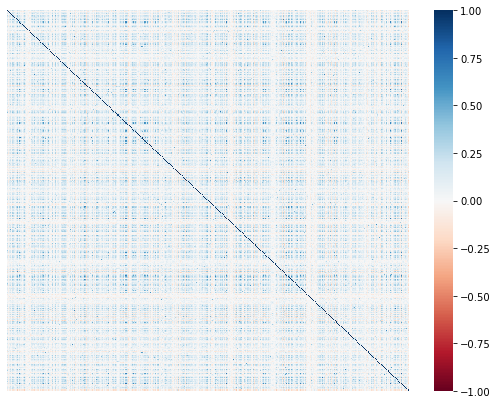

In [142]:
Delta = pd.DataFrame(np.array([(x @ L) for x, L in zip(log_returns_bias.values, res_srwl['Ls'])]),
                     columns=log_returns_bias.columns)
if bias:
    Delta = Delta.iloc[:, :-1]
Delta.index = log_returns.index

Delta_thresh = Delta.abs().quantile(.99)

plt.figure(figsize=(9, 7))
sns.heatmap(Delta.corr(), cmap='RdBu', vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
plt.show()

Worst reconstructed assets: ['CHTR', 'REGN', 'STZ', 'NFLX', 'MKTX', 'DPZ'], 
Best reconstructed assets: ['FITB', 'KEY', 'WELL', 'IP', 'PFG', 'RTX']


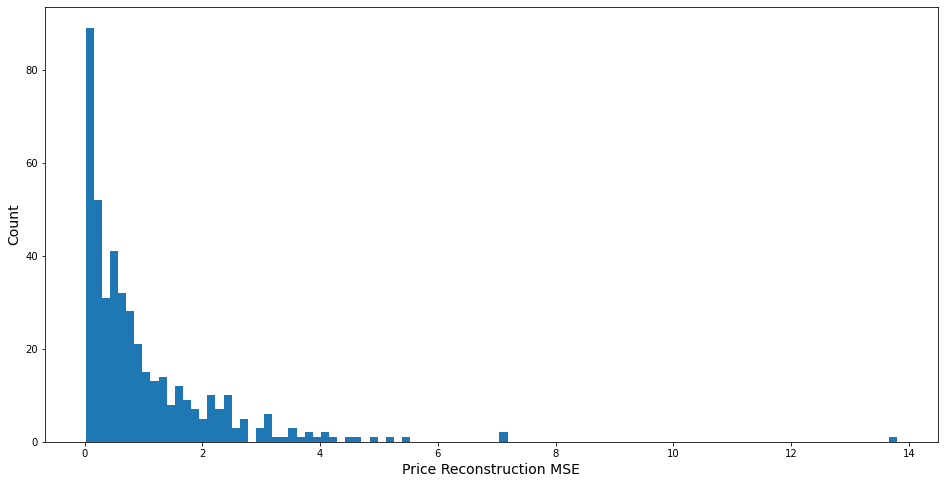

In [143]:
worst_reconstructed_assets = (Delta.cumsum() ** 2).mean().sort_values().iloc[-6:].index.values
best_reconstructed_assets = (Delta.cumsum() ** 2).mean().sort_values().iloc[:6].index.values
print(f'Worst reconstructed assets: {worst_reconstructed_assets.tolist()}, \nBest reconstructed assets: {best_reconstructed_assets.tolist()}')
(Delta.cumsum() ** 2).mean().plot.hist(bins=100)
plt.ylabel('Count', size=14)
plt.xlabel('Price Reconstruction MSE', size=14)
plt.show()

#### Best Reconstruced Signals
Here we plot the 6 best reconstructed price signals. In the following plots we show, for each asset:

1. true vs the reconstruced log returns
2. true vs the reconstruced price
3. squared difference between true and reconstruced price.

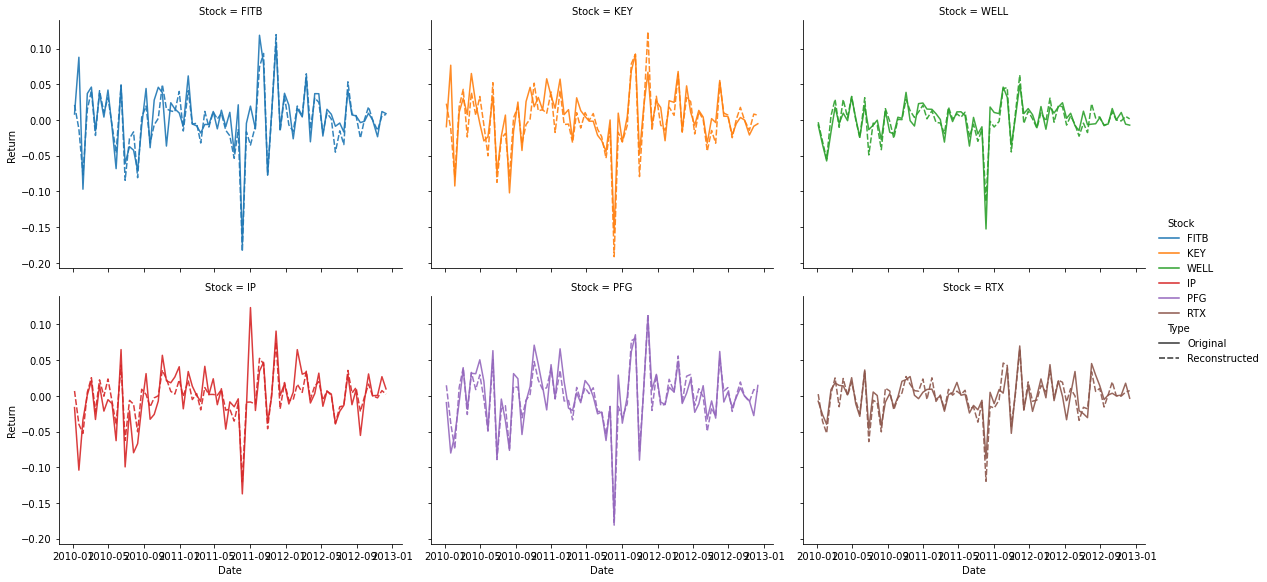

In [144]:
downsampling_factor = 10
best_recon_original_price_melt = (log_returns[best_reconstructed_assets]).iloc[:downsampling_factor * 75:downsampling_factor].reset_index().melt('Date')
best_recon_original_price_melt['Type'] = 'Original'
best_recon_price_melt = (log_returns[best_reconstructed_assets] - Delta[best_reconstructed_assets].values).iloc[:downsampling_factor * 75:downsampling_factor].reset_index().melt('Date')
best_recon_price_melt['Type'] = 'Reconstructed'

sns.relplot(data=pd.concat([best_recon_original_price_melt, best_recon_price_melt]).rename(columns={'variable': 'Stock', 'value': 'Return'}),
            x='Date', y='Return', style='Type', hue='Stock', alpha=.9, kind='line', col='Stock', col_wrap=3, height=4, aspect=4/3)
plt.show()

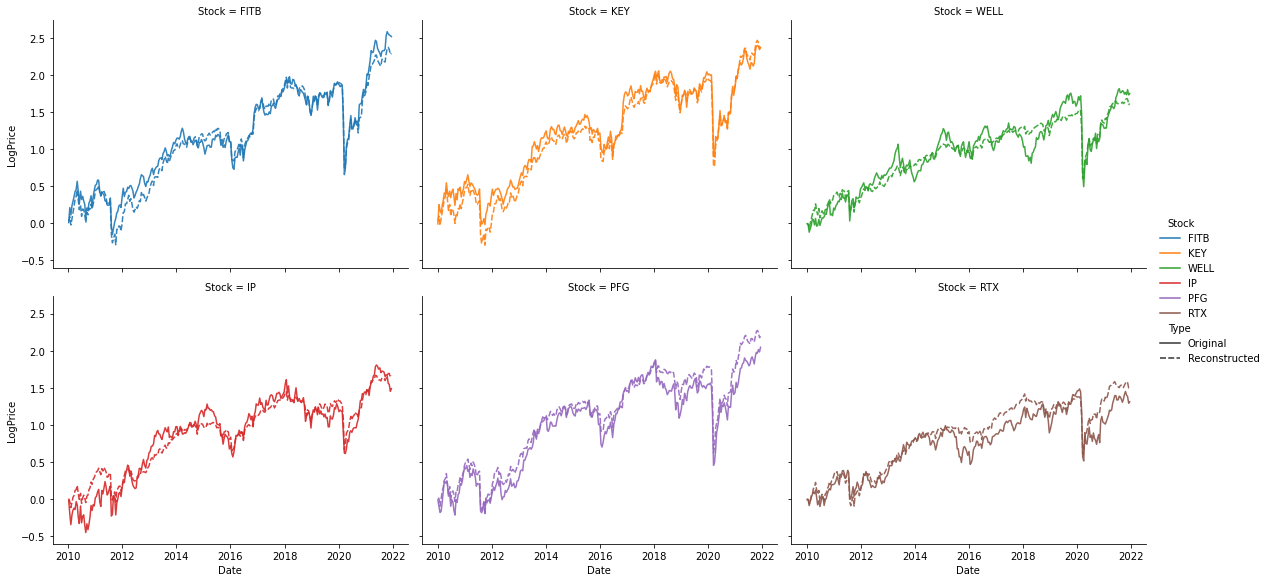

In [145]:
best_recon_original_price_melt = (log_returns[best_reconstructed_assets]).cumsum().iloc[::downsampling_factor].reset_index().melt('Date')
best_recon_original_price_melt['Type'] = 'Original'
best_recon_price_melt = (log_returns[best_reconstructed_assets] - Delta[best_reconstructed_assets].values).cumsum().iloc[::downsampling_factor].reset_index().melt('Date')
best_recon_price_melt['Type'] = 'Reconstructed'

sns.relplot(data=pd.concat([best_recon_original_price_melt, best_recon_price_melt]).rename(columns={'variable': 'Stock', 'value': 'LogPrice'}),
            x='Date', y='LogPrice', style='Type', hue='Stock', alpha=.9, kind='line', col='Stock', col_wrap=3, height=4, aspect=4/3)
plt.show()

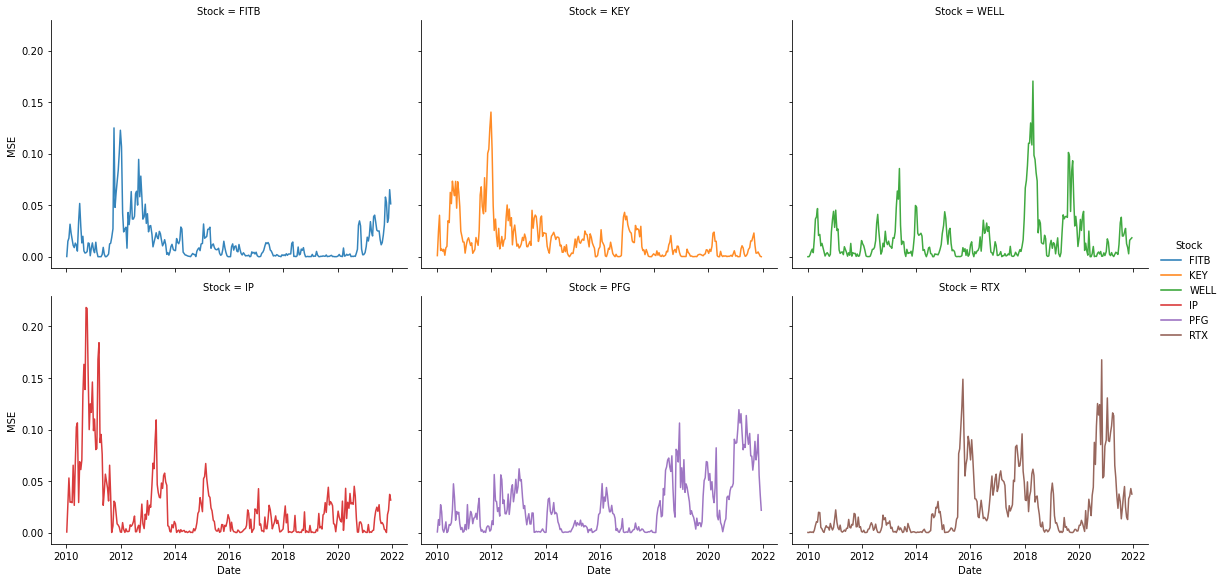

In [146]:
sns.relplot(data=(Delta.cumsum() ** 2)[best_reconstructed_assets].iloc[::downsampling_factor].reset_index().melt('Date').rename(columns={'variable': 'Stock', 'value': 'MSE'}),
            x='Date', y='MSE', hue='Stock', alpha=.9, kind='line', col='Stock', col_wrap=3, height=4, aspect=4/3)
plt.show()

#### Worst Reconstruced Signals
Here we plot the 6 worst reconstructed price signals. In the following plots we show, for each asset:

1. true vs the reconstruced log returns
2. true vs the reconstruced price
3. squared difference between true and reconstruced price.

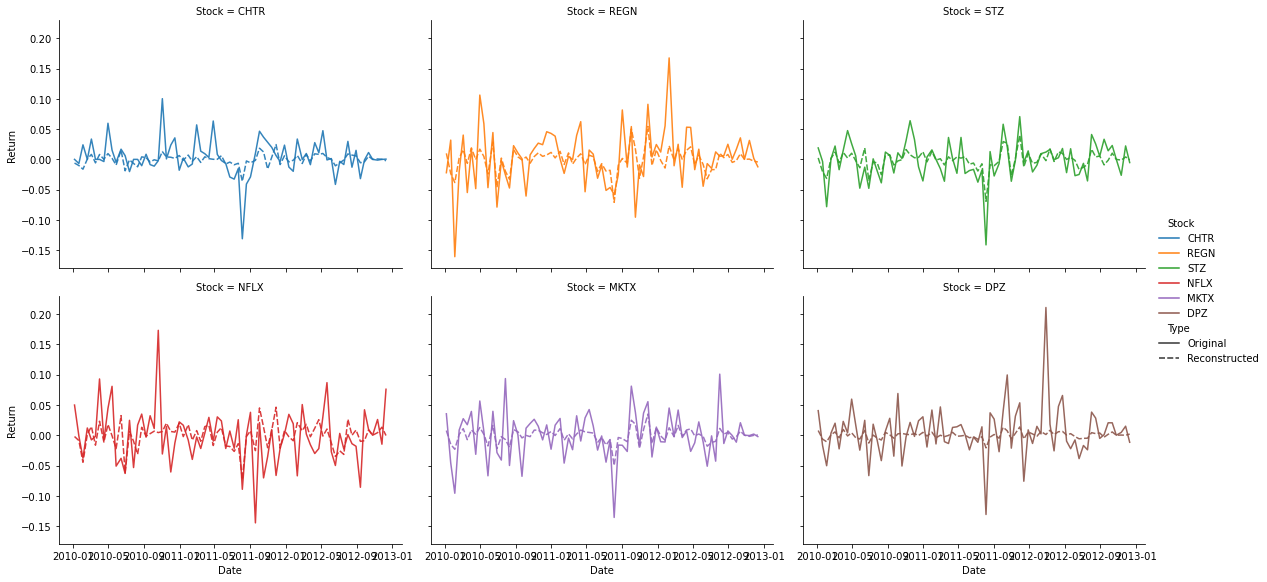

In [147]:
worst_recon_original_price_melt = (log_returns[worst_reconstructed_assets]).iloc[:downsampling_factor * 75:downsampling_factor].reset_index().melt('Date')
worst_recon_original_price_melt['Type'] = 'Original'
worst_recon_price_melt = (log_returns[worst_reconstructed_assets] - Delta[worst_reconstructed_assets].values).iloc[:downsampling_factor * 75:downsampling_factor].reset_index().melt('Date')
worst_recon_price_melt['Type'] = 'Reconstructed'

sns.relplot(data=pd.concat([worst_recon_original_price_melt, worst_recon_price_melt]).rename(columns={'variable': 'Stock', 'value': 'Return'}),
            x='Date', y='Return', style='Type', hue='Stock', alpha=.9, kind='line', col='Stock', col_wrap=3, height=4, aspect=4/3)
plt.show()

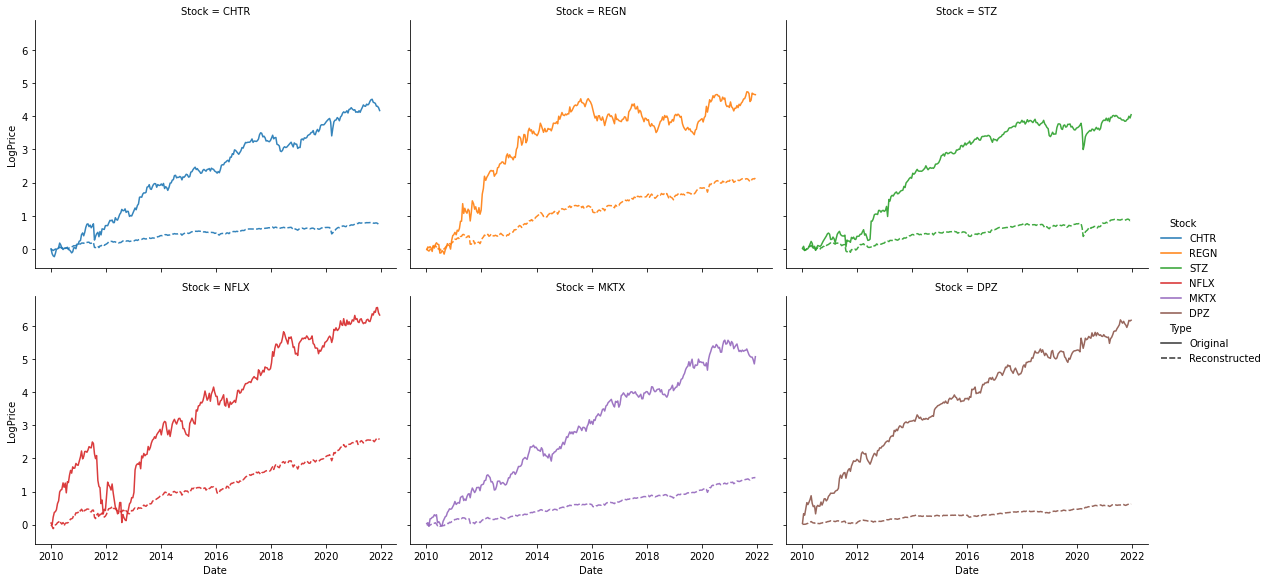

In [148]:
worst_recon_original_price_melt = (log_returns[worst_reconstructed_assets]).cumsum().iloc[::downsampling_factor].reset_index().melt('Date')
worst_recon_original_price_melt['Type'] = 'Original'
worst_recon_price_melt = (log_returns[worst_reconstructed_assets] - Delta[worst_reconstructed_assets].values).cumsum().iloc[::downsampling_factor].reset_index().melt('Date')
worst_recon_price_melt['Type'] = 'Reconstructed'

sns.relplot(data=pd.concat([worst_recon_original_price_melt, worst_recon_price_melt]).rename(columns={'variable': 'Stock', 'value': 'LogPrice'}),
            x='Date', y='LogPrice', style='Type', hue='Stock', alpha=.9, kind='line', col='Stock', col_wrap=3, height=4, aspect=4/3)
plt.show()

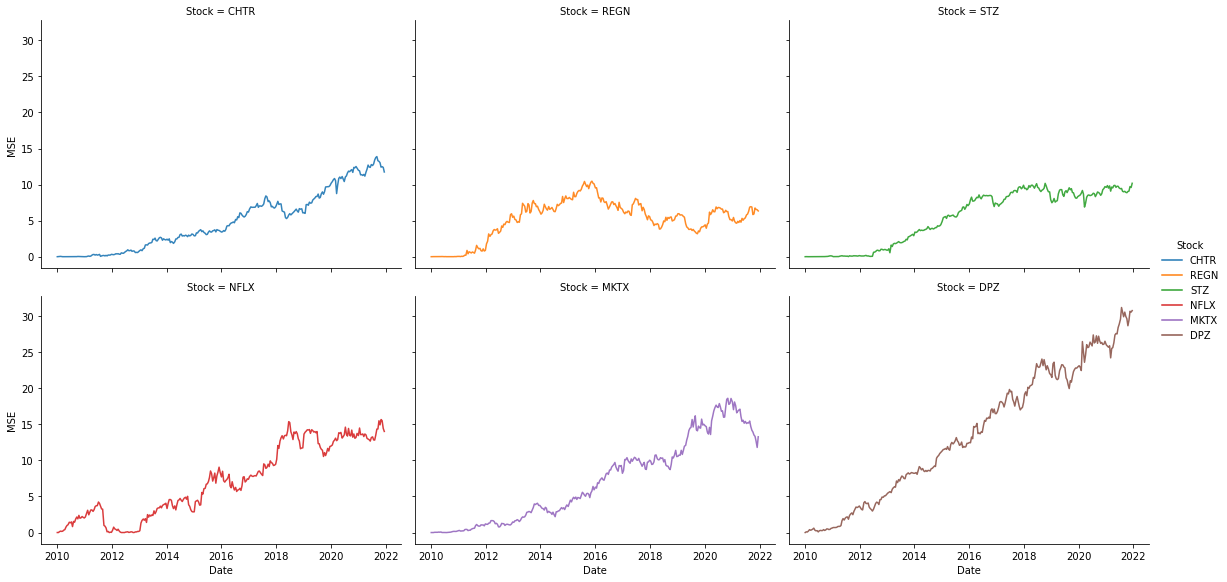

In [149]:
sns.relplot(data=(Delta.cumsum() ** 2)[worst_reconstructed_assets].iloc[::downsampling_factor].reset_index().melt('Date').rename(columns={'variable': 'Stock', 'value': 'MSE'}),
            x='Date', y='MSE', hue='Stock', alpha=.9, kind='line', col='Stock', col_wrap=3, height=4, aspect=4/3)
plt.show()

## Benchmarks

In order to assess the effectiveness of our approch we will compare the results with 2 other methods.

### Exponential Moving Residuals (EMR)

In this case for each time series $f_i(t)$ we compute the exponential moving average as $s_i(t) = \gamma \cdot \boldsymbol{s}(t-1) + (1-\gamma) \cdot \boldsymbol{x}(t)$, where $\gamma = 0.5$ is the *memory* parameter, then we compute the residual as $r_i(t) = f_i(t) - s_(t)$ and we say that an anomaly occurs if $r_i(t)$ is not within the interval $[L, U]$, where $L$ and $U$ are respectively the lower and the upper bounds.

$$
Prediction = \begin{cases}
NotAnomaly & r_i(t) \in [L, U] \\
Anomaly & r_i(t) \notin [L, U] \\
\end{cases}
$$

In our case $L$ and $U$ will be chosen as the $\alpha$ and $1-\alpha$ quantiles of the residuals.

In [150]:
# Set gamma
gamma = .01

# Evaluate the residuals
residuals = log_returns - log_returns.ewm(alpha=gamma).mean()
residual_thresh = residuals.abs().quantile(.99)

### Whitening Transformation

Here we assume $f(t) \sim \mathcal{N}(0, \Sigma)$. The resulting data matrix $X$ can then be transformed into $Y = W X$ where $W$ is a whitening matrix satisfying the condition $ W^{T} W = \Sigma ^{-1}$. $Y$ is now the uncorralated random perturbations matrix associated to each time series. There are infinitely many possible whitening matrices $W$ that all satisfy the above condition, we choose $W = \Sigma^{-1/2}$. 

We say that an anomaly occurs for variable $i$ at time $t$ if the whitened noise is outside of some specified bounds.

$$
Prediction = \begin{cases}
NotAnomaly & Y_{t, i} \in [L, U] \\
Anomaly & Y_{t, i} \notin [L, U] \\
\end{cases}
$$

In our case $L$ and $U$ will be chosen as the $\alpha$ and $1-\alpha$ quantiles of the noise.

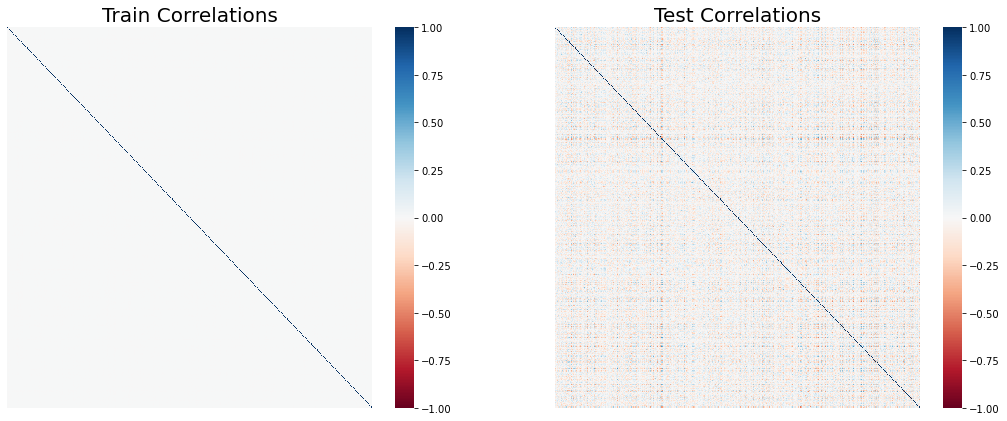

In [151]:
train_size = int(.75 * len(log_returns))
Sigma = log_returns.iloc[:train_size].cov()
W = sqrtm(np.linalg.inv(Sigma))
uncorr_returns = (W @ log_returns.T).T
uncorr_returns.columns = log_returns.columns
uncorr_thresh = uncorr_returns.abs().quantile(.99)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 7))
ax1.set_title('Train Correlations', fontsize=20)
sns.heatmap((W @ log_returns.iloc[:train_size].T).T.corr(), cmap='RdBu', vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax2.set_title('Test Correlations', fontsize=20)
sns.heatmap((W @ log_returns.iloc[train_size:].T).T.corr(), cmap='RdBu', vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
plt.show()

## Noise Corruption

To corrupt our signal we used an additive noise matrix. The corrupted log returns matrix $X^c$ is computed as sum of the original log returns $X$ and a noise matrix $\mathcal{C}$:

$$
\begin{align}
X^c &= X + \mathcal{C} \\
\mathcal{C}_{i, j} \sim \mathcal{N}(s, r) &= \begin{cases}
s & p = r/2 \\
0 & p = 1 - r \\
-s & p = r/2 \\
\end{cases}
\end{align}
$$

where $r$ is the corruption rate and $s$ is the noise strength.

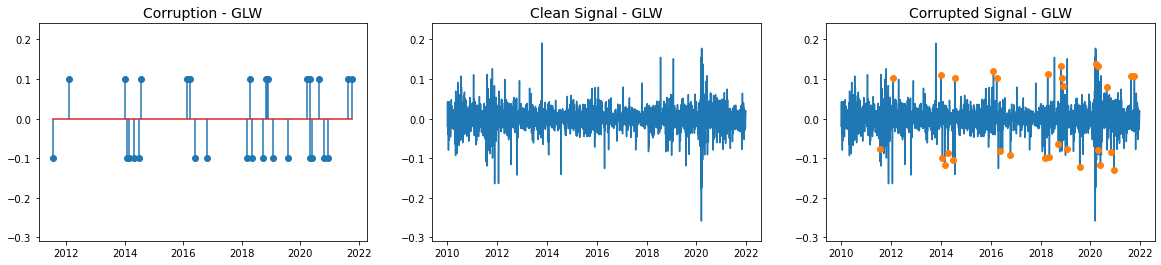

In [182]:
pct_corruption = .01
strength = .1
def create_corruption(pct_corruption = .01, strength = .1):
    noise = (np.random.rand(*log_returns.shape) - .5) * 2
    corruption = np.sign(noise) * (np.abs(noise) > (1-pct_corruption)) * strength
    return corruption
corruption = create_corruption(pct_corruption, strength)
currupted_returns = log_returns + corruption

# Plots
col_idx = np.random.randint(len(log_returns.columns))
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
# Corruption
axs[0].stem(currupted_returns.index[corruption[:, col_idx] != 0], corruption[:, col_idx][corruption[:, col_idx] != 0])
axs[0].set_title(f'Corruption - {log_returns.columns[col_idx]}', fontsize=14)
axs[0].set_ylim(currupted_returns.iloc[:, col_idx].min() - 0.05, currupted_returns.iloc[:, col_idx].max() + 0.05)
# Clean Signal
axs[1].plot(log_returns.iloc[:, col_idx])
axs[1].set_title(f'Clean Signal - {log_returns.columns[col_idx]}', fontsize=14)
axs[1].set_ylim(currupted_returns.iloc[:, col_idx].min() - 0.05, currupted_returns.iloc[:, col_idx].max() + 0.05)
# Corrupted Signal
axs[2].plot(currupted_returns.iloc[:, col_idx])
axs[2].plot(currupted_returns.index[corruption[:, col_idx] != 0], currupted_returns.iloc[:, col_idx][corruption[:, col_idx] != 0], 'o', color='tab:orange')
axs[2].set_title(f'Corrupted Signal - {log_returns.columns[col_idx]}', fontsize=14)
axs[2].set_ylim(currupted_returns.iloc[:, col_idx].min() - 0.05, currupted_returns.iloc[:, col_idx].max() + 0.05)
plt.show()

## Anomaly Detection

As we mentioned before we say that an anomaly occurs if the value of the transformed signal is outside the $1-\alpha$ quantile interval for that signal. We choose $\alpha = 1\%$ therefore for each method, i.e. *Delta* (our), *residuals*, *whitening*, for each asset we compute the $99\%$ interval on the clean signal and we use such interval to detect when an anomaly occurs.

In [36]:
# Commpute Delta
Delta = compute_Delta(currupted_returns)

# Compute residuals
residuals = currupted_returns - currupted_returns.ewm(alpha=gamma).mean()

# Compute uncorrelated returns
train_size = int(.75 * len(currupted_returns))
Sigma = currupted_returns.iloc[:train_size].cov()
W = sqrtm(np.linalg.inv(Sigma))
uncorr_returns = (W @ currupted_returns.T).T
uncorr_returns.columns = currupted_returns.columns

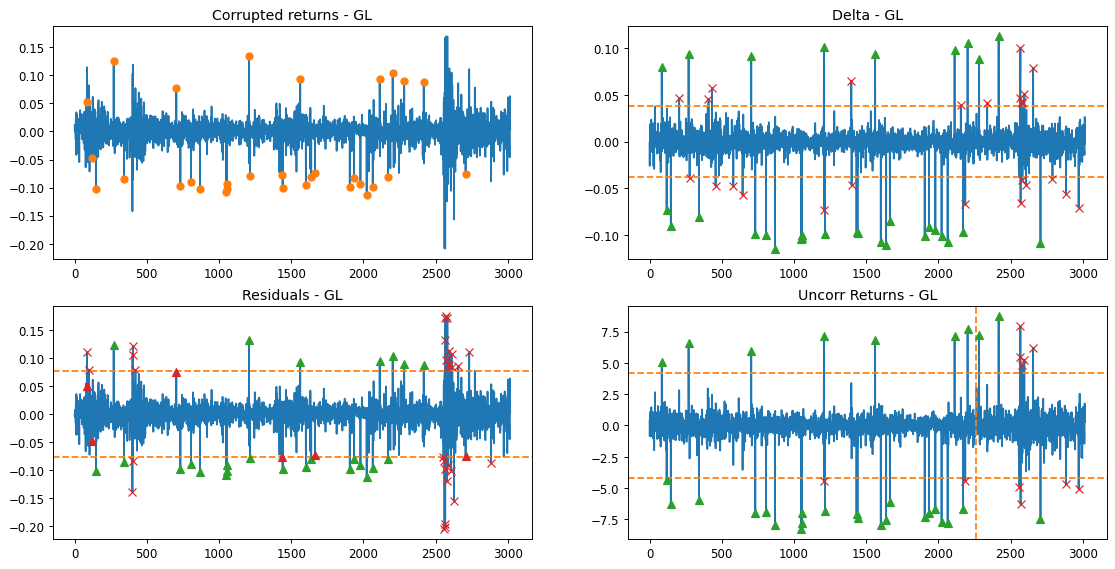

In [37]:
def plot_markers(signal, y_true, y_pred, ax):
    tpn = y_true & y_pred
    fp = (~y_true) & y_pred
    fn = y_true & (~y_pred)
    ax.plot(np.arange(signal.size)[tpn], signal[tpn], '^', color='tab:green')
    ax.plot(np.arange(signal.size)[fp], signal[fp], 'x', color='tab:red')
    ax.plot(np.arange(signal.size)[fn], signal[fn], '^', color='tab:red')

fig, axs = plt.subplots(2, 2, dpi=85)
axs = axs.flatten()
j = np.random.randint(currupted_returns.shape[1])

currupted_returns.iloc[:, j].reset_index(drop=True).plot(ax=axs[0])
axs[0].plot(np.arange(len(log_returns))[corruption[:, j] != 0], currupted_returns.iloc[:, j][corruption[:, j] != 0], 'o')
axs[0].set_title(f'Corrupted returns - {currupted_returns.columns[j]}')

Delta.iloc[:, j].reset_index(drop=True).plot(ax=axs[1])
# axs[1].plot(np.arange(len(log_returns))[corruption[:, j] != 0], Delta.iloc[:, j][corruption[:, j] != 0], 'o')
axs[1].set_title(f'Delta - {currupted_returns.columns[j]}')
axs[1].axhline(Delta_thresh.iloc[j], color='tab:orange', ls='--')
axs[1].axhline(-Delta_thresh.iloc[j], color='tab:orange', ls='--')
plot_markers(Delta.iloc[:, j], corruption[:, j] != 0, Delta.iloc[:, j].abs() > Delta_thresh.iloc[j], axs[1])

residuals.iloc[:, j].reset_index(drop=True).plot(ax=axs[2])
# axs[2].plot(np.arange(len(residuals))[corruption[:, j] != 0], residuals.iloc[:, j][corruption[:, j] != 0], 'o')
axs[2].set_title(f'Residuals - {currupted_returns.columns[j]}')
axs[2].axhline(residual_thresh.iloc[j], color='tab:orange', ls='--')
axs[2].axhline(-residual_thresh.iloc[j], color='tab:orange', ls='--')
plot_markers(residuals.iloc[:, j], corruption[:, j] != 0, residuals.iloc[:, j].abs() > residual_thresh.iloc[j], axs[2])

uncorr_returns.iloc[:, j].reset_index(drop=True).plot(ax=axs[3])
# axs[3].plot(np.arange(len(uncorr_returns))[corruption[:, j] != 0], uncorr_returns.iloc[:, j][corruption[:, j] != 0], 'o')
axs[3].set_title(f'Uncorr Returns - {currupted_returns.columns[j]}')
axs[3].axhline(uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[3].axhline(-uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[3].axvline(train_size, color='tab:orange', ls='--')
plot_markers(uncorr_returns.iloc[:, j], corruption[:, j] != 0, uncorr_returns.iloc[:, j].abs() > uncorr_thresh.iloc[j], axs[3])
plt.show()

The vertical line in the *Uncorrelated Returns* plot above represents the boundary between train (on the left-hand side) and the test date (on the right-hand side). Below you can see the same plot using different train size ($25\%, 50\%, 75\%$), in the following analyses we used a $75\%$ split since in our opinion it represents the best tradeoff between train and test.

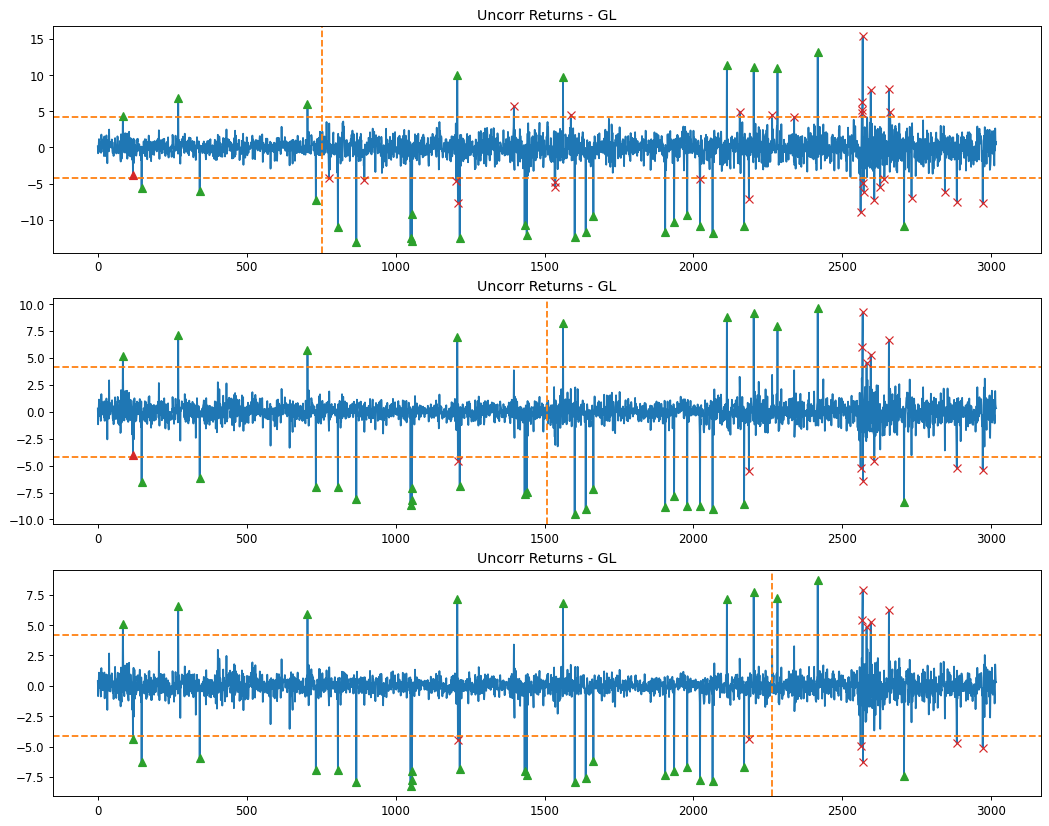

In [38]:
fig, axs = plt.subplots(3, dpi=85, figsize=(15, 12))
axs = axs.flatten()

# Compute uncorrelated returns - Train size: 25%
train_size = int(.25 * len(currupted_returns))
Sigma = currupted_returns.iloc[:train_size].cov()
W = sqrtm(np.linalg.inv(Sigma))
uncorr_returns = (W @ currupted_returns.T).T
uncorr_returns.columns = currupted_returns.columns

# Plot
uncorr_returns.iloc[:, j].reset_index(drop=True).plot(ax=axs[0])
axs[0].set_title(f'Uncorr Returns - {currupted_returns.columns[j]}')
axs[0].axhline(uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[0].axhline(-uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[0].axvline(train_size, color='tab:orange', ls='--')
plot_markers(uncorr_returns.iloc[:, j], corruption[:, j] != 0, uncorr_returns.iloc[:, j].abs() > uncorr_thresh.iloc[j], axs[0])


# Compute uncorrelated returns - Train size: 50%
train_size = int(.5 * len(currupted_returns))
Sigma = currupted_returns.iloc[:train_size].cov()
W = sqrtm(np.linalg.inv(Sigma))
uncorr_returns = (W @ currupted_returns.T).T
uncorr_returns.columns = currupted_returns.columns

# Plot
uncorr_returns.iloc[:, j].reset_index(drop=True).plot(ax=axs[1])
axs[1].set_title(f'Uncorr Returns - {currupted_returns.columns[j]}')
axs[1].axhline(uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[1].axhline(-uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[1].axvline(train_size, color='tab:orange', ls='--')
plot_markers(uncorr_returns.iloc[:, j], corruption[:, j] != 0, uncorr_returns.iloc[:, j].abs() > uncorr_thresh.iloc[j], axs[1])


# Compute uncorrelated returns - Train size: 75%
train_size = int(.75 * len(currupted_returns))
Sigma = currupted_returns.iloc[:train_size].cov()
W = sqrtm(np.linalg.inv(Sigma))
uncorr_returns = (W @ currupted_returns.T).T
uncorr_returns.columns = currupted_returns.columns

# Plot
uncorr_returns.iloc[:, j].reset_index(drop=True).plot(ax=axs[2])
axs[2].set_title(f'Uncorr Returns - {currupted_returns.columns[j]}')
axs[2].axhline(uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[2].axhline(-uncorr_thresh.iloc[j], color='tab:orange', ls='--')
axs[2].axvline(train_size, color='tab:orange', ls='--')
plot_markers(uncorr_returns.iloc[:, j], corruption[:, j] != 0, uncorr_returns.iloc[:, j].abs() > uncorr_thresh.iloc[j], axs[2])

plt.show()

In [39]:
def analyze_prediction(Y_true, signal, thresholds):
    results = []
    for i, col in enumerate(signal.columns):
        y_true = Y_true[:, i] != 0
        y_pred = signal[col].abs() > thresholds[col]
        results.append({
            'Ticker': col,
            'F1_score': metrics.f1_score(y_true, y_pred),
            'Precision': metrics.precision_score(y_true, y_pred),
            'Recall': metrics.recall_score(y_true, y_pred),
            'ROC': metrics.roc_auc_score(y_true, signal[col].abs()),
        })
    return pd.DataFrame(results)

In [40]:
classification_results = []

for strength in [.05, .1, .25]:
    for pct_corruption in [.01, .025, .1]:
        corruption = create_corruption(pct_corruption, strength)
        currupted_returns = log_returns + corruption
        
        # Commpute Delta
        Delta = compute_Delta(currupted_returns)

        # Evaluate results Delta
        df_Delta = analyze_prediction(corruption, Delta, Delta_thresh)
        df_Delta['Method'] = 'Delta'
        df_Delta['CorruptionRate'] = pct_corruption
        df_Delta['Strength'] = strength
        classification_results.append(df_Delta)
        
        # Compute residuals
        residuals = currupted_returns - currupted_returns.ewm(alpha=gamma).mean()

        # Evaluate results residuals
        df_residuals = analyze_prediction(corruption, residuals, residual_thresh)
        df_residuals['Method'] = 'Residuals'
        df_residuals['CorruptionRate'] = pct_corruption
        df_residuals['Strength'] = strength
        classification_results.append(df_residuals)

        # Compute uncorrelated returns
        Sigma = currupted_returns.iloc[:train_size].cov()
        W = sqrtm(np.linalg.inv(Sigma))
        uncorr_returns = (W @ currupted_returns.T).T
        uncorr_returns.columns = currupted_returns.columns

        # Evaluate results whitening
        df_uncorr = analyze_prediction(corruption, uncorr_returns, uncorr_thresh)
        df_uncorr['Method'] = 'Whitening'
        df_uncorr['CorruptionRate'] = pct_corruption
        df_uncorr['Strength'] = strength
        classification_results.append(df_uncorr)

df_classification_results = pd.concat(classification_results)

  0%|          | 0/3017 [00:00<?, ?it/s]

  0%|          | 0/3017 [00:00<?, ?it/s]

  0%|          | 0/3017 [00:00<?, ?it/s]

  0%|          | 0/3017 [00:00<?, ?it/s]

  0%|          | 0/3017 [00:00<?, ?it/s]

  0%|          | 0/3017 [00:00<?, ?it/s]

C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn

  0%|          | 0/3017 [00:00<?, ?it/s]

  0%|          | 0/3017 [00:00<?, ?it/s]

  0%|          | 0/3017 [00:00<?, ?it/s]

C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn

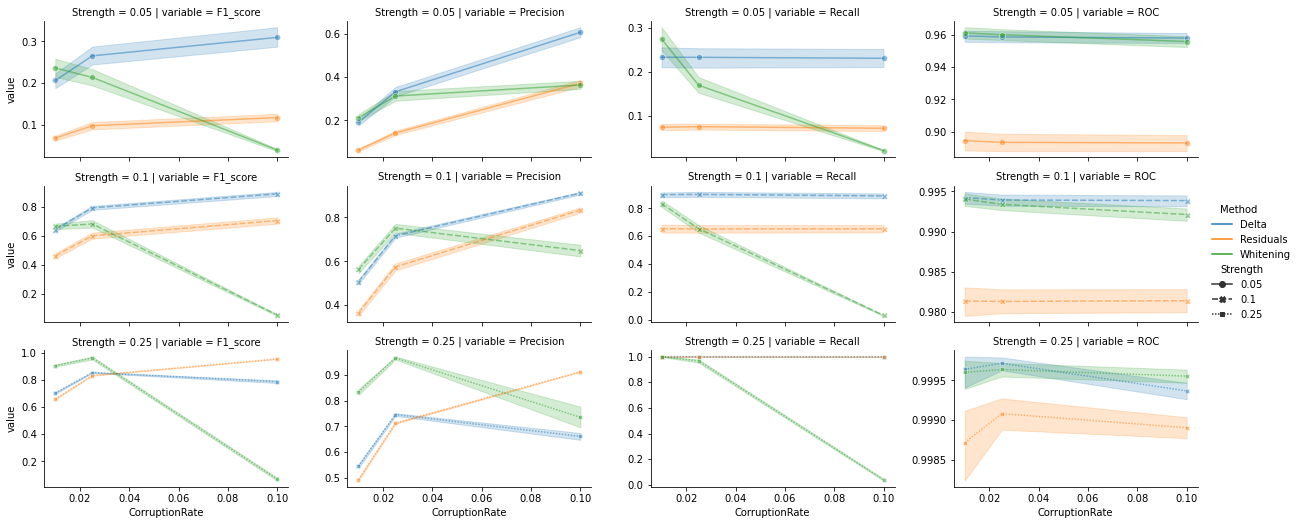

In [41]:
sns.relplot(data = df_classification_results.melt(['Method', 'CorruptionRate', 'Strength', 'Ticker']), 
             x='CorruptionRate', y='value', hue='Method', style='Strength', alpha=.5, kind='line', 
            col='variable', row='Strength', markers=True, height=2.4, aspect=1.75, facet_kws=dict(sharey=False))
plt.show()

From the plot above we can derive many interesting considerations:

* looking at the F1 scores we can notice that in the case of low/moderate noise *strength* our approach almost always outperforms the others;
* this is due to the rapid decline in the *recall* of the whitening approach as we increase the *corruption rate*. We think that the reason behind this decline lies in the effect that the noise has on the correlation matrix and it does not show up in our approach becauese of the high amount of regularization applied; 
* since the residuals approach does not use the corrupted correlation matrix its results are the most stable in the case of high noise *strength* and high *corruption rate*
* finally, if we look at the area under the ROC curve we see that the overall performance of both our and the whitening approaches are very similar (in the following paragraph we'll discuss why in more details) while the residuals approach show consistently poorer performance.

## Conclusions

In conlcusion we discuss the similarities between the whitening approch and our together with pros and cons of the two. 

As we have seen above our approach and the whitening achieve comparable results this is because **our approach can indeed be seen as decorrelation transformation**. Each variable residuals are independent of all the variables therefore the reconstruction errors are independent one another. 

Now that we have clear the relation between our approach and whitening we can discuss the pros and cons of the two:

**Pros**:

- it is regularized therefore it is robust to noise corruption and collinearity among variables
- the resulting decorrelation matrix $L$ is sparse and can be used as Laplacian to describe the underling dependency graph
- the computation can be parallelized using GPUs therefore it can scale to large matrices
- it is recursive therefore it is able to capture slow changes in the $L$ entries over time and it does not need to split the dataset in train and test
- by design it provides, for each variable, an approximation computed using all the other variables; this jointly the mean reverting property of the price reconstruction errors can be used to create market neutral statistical arbitrage strategies.

**Cons**:

- the gradient descent algorithm used requires a lot of iteration to converge
- there are many parameters to tune (i.e. $\alpha, \beta, \lambda, \mu, B,$ etc.)